# Fetal Nuchal Translucency Segmenter Model

In [1]:
# Imports
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from collections import Counter
import cv2
import torch.optim as optim
from segmentation_models_pytorch.utils.metrics import IoU

2025-06-26 20:09:13.588244: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 20:09:13.604749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Global constants
TARGET_SIZE = (400, 600)  # target size for images and masks
MLFLOW_URI = "http://localhost:8080"
BATCH_SIZE = 5 
NUM_EPOCHS = 50
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 10
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_nt_segmenter.pth")
ONNX_SAVE_DIR = "onnx_exports"
MODEL_NAME = "nt_segmenter"
ONNX_MODEL_NAME = f"{MODEL_NAME}.onnx"
MODEL_SAVE_PATH = os.path.join(ONNX_SAVE_DIR, ONNX_MODEL_NAME)
RUN_NAME = f"{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"

In [3]:
# Logging with tensorboard and mlflow
tb_writer = SummaryWriter(log_dir='tb_logs/nt_segmenter')
mlflow.set_tracking_uri(MLFLOW_URI)
experiment = mlflow.set_experiment("nt_segmenter")

In [4]:
IMG_DIR = 'preprocessed_images'
MASK_DIR = "segmentations"

In [5]:
# Setup device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
# check if windows is being used and try to import torch-directml
elif os.name == 'nt':
    try:
        import torch_directml
        device = torch_directml.device()
    except ImportError:
        pass
print(f"Using device: {device}")

Using device: cuda


## Step 1: Dataset Configuration

In [6]:
# Gather and filter filenames
all_imgs = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
valid_imgs = [
    img for img in all_imgs
    if os.path.exists(os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png"))
]

# Split into train / test (80/20)
train_files, test_files = train_test_split(
    valid_imgs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Build full paths lists
train_imgs  = [os.path.join(IMG_DIR,  img) for img in train_files]
train_masks = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in train_files]

test_imgs   = [os.path.join(IMG_DIR,  img) for img in test_files]
test_masks  = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in test_files]

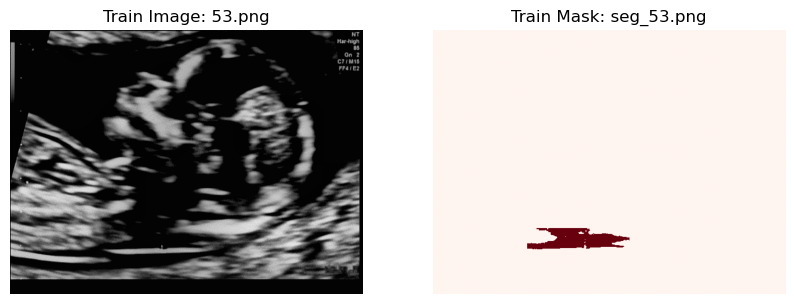

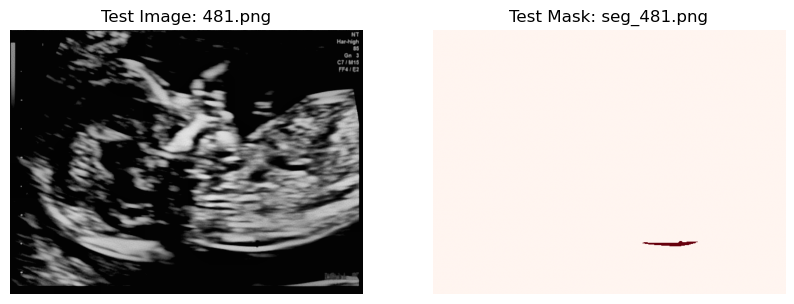

In [7]:
# Convert to lists if they’re Paths
train_files = [f.name if hasattr(f, 'name') else f for f in train_files]
test_files  = [f.name if hasattr(f, 'name') else f for f in test_files]

# Choose random samples
train_sample = random.choice(train_files)
test_sample  = random.choice(test_files)

# Paths
train_img  = os.path.join(IMG_DIR, train_sample)
train_mask = os.path.join(MASK_DIR, f"seg_{os.path.splitext(train_sample)[0]}.png")
test_img   = os.path.join(IMG_DIR, test_sample)
test_mask  = os.path.join(MASK_DIR,  f"seg_{os.path.splitext(test_sample)[0]}.png")

def plot_pair(img_path, mask_path, title):
    img  = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)
    if mask.max() <= 1.0:
        mask = mask * 255

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"{title} Image: {os.path.basename(img_path)}")
    ax1.axis('off')

    ax2.imshow(mask, cmap='Reds')
    ax2.set_title(f"{title} Mask: {os.path.basename(mask_path)}")
    ax2.axis('off')
    plt.show()

# Display
plot_pair(train_img, train_mask, 'Train')
plot_pair(test_img, test_mask,   'Test')

In [8]:
print(f"Number of train images: {len(train_imgs)}")
print(f"Number of train masks:  {len(train_masks)}")

print(f"Number of test images:  {len(test_imgs)}")
print(f"Number of test masks:   {len(test_masks)}")

Number of train images: 888
Number of train masks:  888
Number of test images:  222
Number of test masks:   222


In [9]:
def get_shapes(paths):
    shapes = [cv2.imread(p, cv2.IMREAD_UNCHANGED).shape[:2] for p in paths]
    return Counter(shapes)

In [10]:
print(f"Number of train images: {len(train_imgs)}")
print(f"Train image dimensions (HxW) frequency:")
for (h, w), cnt in get_shapes(train_imgs).items():
    print(f"  {h}x{w}: {cnt}")

print(f"\nNumber of train masks: {len(train_masks)}")
print(f"Train mask dimensions (HxW) frequency:")
for (h, w), cnt in get_shapes(train_masks).items():
    print(f"  {h}x{w}: {cnt}")

print(f"\nNumber of test images: {len(test_imgs)}")
print(f"Test image dimensions (HxW) frequency:")
for (h, w), cnt in get_shapes(test_imgs).items():
    print(f"  {h}x{w}: {cnt}")

print(f"\nNumber of test masks: {len(test_masks)}")
print(f"Test mask dimensions (HxW) frequency:")
for (h, w), cnt in get_shapes(test_masks).items():
    print(f"  {h}x{w}: {cnt}")

Number of train images: 888
Train image dimensions (HxW) frequency:
  450x600: 888

Number of train masks: 888
Train mask dimensions (HxW) frequency:
  450x600: 888

Number of test images: 222
Test image dimensions (HxW) frequency:
  450x600: 222

Number of test masks: 222
Test mask dimensions (HxW) frequency:
  450x600: 222


In [11]:
class FetusSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        assert len(image_paths) == len(mask_paths), "Images and masks counts must match"
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms  = transforms or T.Compose([
            T.Resize((256,256)),      # optional: down/up-sample
            T.ToTensor(),             # [0–255] → [0–1], shape [C,H,W]
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load grayscale image & mask
        img  = Image.open(self.image_paths[idx]).convert('L')
        msk  = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply identical transforms
        img_t = self.transforms(img)
        msk_t = self.transforms(msk)
        
        # Optionally: binarize mask (if not already 0/1)
        msk_t = (msk_t > 0.5).float()
        
        return img_t, msk_t

In [12]:
transforms = T.Compose([
    T.ToTensor(),
])

# 1) Create datasets
train_ds = FetusSegDataset(train_imgs,  train_masks, transforms=transforms)
test_ds  = FetusSegDataset(test_imgs,   test_masks,  transforms=transforms)

# 2) Create loaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=(False if device == 'cpu' else True),
    num_workers=(0 if os.name == 'nt' else 4)
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=(False if device == 'cpu' else True),
    num_workers=(0 if os.name == 'nt' else 4)
)

# 3) Quick check
imgs, masks = next(iter(train_loader))
print("Images batch:", imgs.shape)   # e.g. [8, 1, 450, 600]
print("Masks batch: ", masks.shape)  # e.g. [8, 1, 450, 600]

Images batch: torch.Size([5, 1, 450, 600])
Masks batch:  torch.Size([5, 1, 450, 600])


In [13]:
# Check values
print("Max value in images batch:", imgs.max().item())  # should be ~1.0
print("Min value in images batch:", imgs.min().item())  # should be ~0.0
print("Max value in masks batch:", masks.max().item())  # should be 1
print("Min value in masks batch:", masks.min().item())  # should be 0

Max value in images batch: 0.8705882430076599
Min value in images batch: 0.003921568859368563
Max value in masks batch: 1.0
Min value in masks batch: 0.0


## Step 2: Model Definition

In [14]:
# 1) Building blocks
class DoubleConv(nn.Module):
    """(conv ⇒ ReLU ⇒ conv ⇒ ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        # choose upsampling method
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            mid_ch = in_ch // 2
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
            mid_ch = in_ch // 2

        self.conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        # x1 is decoder input, x2 is encoder skip connection
        x1 = self.up(x1)
        # input is CHW, adjust pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        # concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """1x1 conv to map to output channels"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# 2) UNet assembly
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, bilinear=True):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.bilinear     = bilinear

        # encoder (contracting path)
        self.inc    = DoubleConv(in_channels, 64)
        self.down1  = Down(64, 128)
        self.down2  = Down(128, 256)
        self.down3  = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4  = Down(512, 1024 // factor)

        # decoder (expansive path)
        self.up1    = Up(1024, 512 // factor, bilinear)
        self.up2    = Up(512, 256 // factor, bilinear)
        self.up3    = Up(256, 128 // factor, bilinear)
        self.up4    = Up(128, 64, bilinear)

        # final 1x1 convolution
        self.outc   = OutConv(64, out_channels)

    def forward(self, x):
        # encoding
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 1024

        # decoding with skip connections
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)

        logits = self.outc(x)
        return logits

In [15]:
model  = UNet(in_channels=1, out_channels=1, bilinear=True).to(device)

In [16]:
# Binary segmentation: logits → mask
loss_fn   = nn.BCEWithLogitsLoss()
metric_fn = IoU(threshold=0.5) 

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

## Step 3: Training

In [17]:
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [18]:
# Initial values for early stopping
best_val_iou = 0.0
epochs_no_improve = 0

with mlflow.start_run(run_name=RUN_NAME):
    MLFLOW_RUN_ID = mlflow.active_run().info.run_id
    # Log hyperparameters
    mlflow.log_params({
        "num_epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "initial_learning_rate": LEARNING_RATE,
        "model_type": "FetusNTSegmenter",
        "backbone": "UNet"
    })
    for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Epochs", position=0, leave=True):
        # Train
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc="Training Batches", position=1, leave=False)
        model.train()
        for imgs, masks in train_pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss   = loss_fn(logits, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        train_pbar.close()
        epoch_train_loss = running_loss / len(train_loader.dataset)
        tb_writer.add_scalar('Loss/train', epoch_train_loss, epoch)

        # Validation
        val_loss, val_iou = 0.0, 0.0
        val_pbar = tqdm(test_loader, desc=f'Validation Batches', position=2, leave=False)
        model.eval()
        with torch.no_grad():
            for imgs, masks in val_pbar:
                imgs, masks = imgs.to(device), masks.to(device)
                logits = model(imgs)
                loss = loss_fn(logits, masks)
                val_loss += loss.item() * imgs.size(0)
                preds = torch.sigmoid(logits)
                val_iou += metric_fn(preds, masks).item() * imgs.size(0)
        val_pbar.close()
        epoch_val_loss = val_loss / len(test_loader.dataset)
        epoch_val_iou  = val_iou  / len(test_loader.dataset)
        tb_writer.add_scalar('Loss/val', epoch_val_loss, epoch)
        tb_writer.add_scalar('IoU/val', epoch_val_iou, epoch)
        scheduler.step(epoch_val_loss)

        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": epoch_train_loss,
            "val_loss": epoch_val_loss,
            "val_iou": epoch_val_iou,
            "current_learning_rate": optimizer.param_groups[0]['lr']
        }, step=epoch)

        # Early stopping and checkpoint
        if epoch_val_iou > best_val_iou:
            best_val_iou = epoch_val_iou
            epochs_no_improve = 0
            torch.save(model.state_dict(), CHECKPOINT_PATH)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch}. Best val IoU: {best_val_iou:.4f}")
                break
    # Close TensorBoard writer
    tb_writer.close()
    
    # Load best weights at the end
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

    # Save the final model
    if not os.path.exists(ONNX_SAVE_DIR):
        os.makedirs(ONNX_SAVE_DIR)
    dummy_input = torch.randn(1, 1, TARGET_SIZE[0], TARGET_SIZE[1], device=device)
    torch.onnx.export(
        model, 
        dummy_input, 
        MODEL_SAVE_PATH, 
        input_names=['input'], 
        output_names=['output'],
        opset_version=11,
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    mlflow.log_artifact(MODEL_SAVE_PATH)
    mlflow.log_metrics({
        "final_val_iou": best_val_iou
    })

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
   

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
   

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Training Batches:   0%|          | 0/178 [01:20<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOS

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
   

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
   

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

^^^^^^^^^^^^^^^^^
^AssertionError^: can only test a child process^
^
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>
Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>Traceback (most recent call last):
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>if w.is_alive():

Traceback (most recent call last):
   File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
       self._shutdown_workers() 
   File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 ^    ^if w.is_alive():^
^ ^^  ^ ^ ^Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x77043c15108

Training Batches:   0%|          | 0/178 [00:00<?, ?it/s]

^^^ ^^ ^^ 
^  ^  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    ^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^ ^assert self._parent_pid == os.getpid(), 'can only test a child process' 
^Exception ignored in:  ^  ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x77043c151080>^  
^  Traceback (most recent call last):
^    File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^  
      ^  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers() ^    
^ assert self._parent_pid == os.getpid(), 'can only test a child process'^  File "/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/torch/utils/data/data

Validation Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Early stopping at epoch 37. Best val IoU: 0.6763
🏃 View run 20250626_200914 at: http://localhost:8080/#/experiments/582715259102895611/runs/e5500a3794694ab389491a4b9b9ee4a8
🧪 View experiment at: http://localhost:8080/#/experiments/582715259102895611


## Step 4: Evaluation

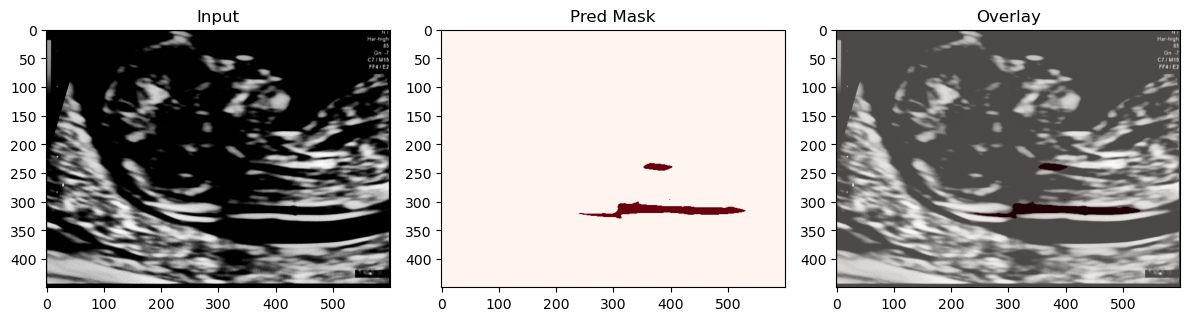

In [19]:
# Set model to evaluation mode
model.eval()

# Single-image inference example
img, _ = next(iter(test_loader))
img = img.to(device)
with torch.no_grad():
    logits = model(img)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

# Visualize first sample
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img[0,0].cpu(), cmap='gray')
plt.title("Input")
plt.subplot(1,3,2)
plt.imshow(preds[0,0].cpu(), cmap='Reds')
plt.title("Pred Mask")
plt.subplot(1,3,3)
plt.imshow(img[0,0].cpu(), cmap='gray'); 
plt.imshow(preds[0,0].cpu(), cmap='Reds', alpha=0.3)
plt.title("Overlay")
plt.tight_layout()
plt.show()


## Step 5: Register model version in MLFlow

In [20]:
model_version = mlflow.register_model(
    model_uri=f"{experiment.artifact_location}/{MLFLOW_RUN_ID}/artifacts/{ONNX_MODEL_NAME}",
    name=MODEL_NAME
)

Registered model 'nt_segmenter' already exists. Creating a new version of this model...
2025/06/26 21:24:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nt_segmenter, version 3
Created version '3' of model 'nt_segmenter'.
